In [1]:
# %load_ext autoreload
# %autoreload 2
import kaolin as kal
from torchvision.transforms import ToTensor
from easydict import EasyDict
import torch
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
# import nvdiffrast
# !pip install easydict
# !pip install kaolin==0.14.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.13.1_cu117.html

In [2]:
def compute_vertex_normals(faces, face_normals, num_vertices=None):
    r"""Computes normals for every vertex by averaging face normals
    assigned to that vertex for every face that has this vertex.

    Args:
       faces (torch.LongTensor): vertex indices of faces of a fixed-topology mesh batch with
            shape :math:`(\text{num_faces}, \text{face_size})`.
       face_normals (torch.FloatTensor): pre-normalized xyz normal values
            for every vertex of every face with shape
            :math:`(\text{batch_size}, \text{num_faces}, \text{face_size}, 3)`.
       num_vertices (int, optional): number of vertices V (set to max index in faces, if not set)

    Return:
        (torch.FloatTensor): of shape (B, V, 3)
    """
    
    if num_vertices is None:
        num_vertices = int(faces.max()) + 1


    B = face_normals.shape[0]
    V = num_vertices
    F = faces.shape[0]
    FSz = faces.shape[1]
    # print(B, V, F, FSz)

    vertex_normals = torch.zeros((B, V, 3), dtype=face_normals.dtype, device=face_normals.device)
    counts = torch.zeros((B, V), dtype=face_normals.dtype, device=face_normals.device)

    # print(vertex_normals.shape)
    faces = faces.unsqueeze(0)
    fake_counts = torch.ones((B, F), dtype=face_normals.dtype, device=face_normals.device)
    #              B x F          B x F x 3
    # self[index[i][j][k]][j][k] += src[i][j][k]  # if dim == 0
    # self[i][index[i][j][k]][k] += src[i][j][k]  # if dim == 1
    
    for i in range(FSz):
        # print(faces[..., i:i + 1].repeat(1, 1, 3).shape) ## torch.Size([1, F, 3])
        # print(face_normals.shape)                        ## torch.Size([1, F])
        vertex_normals.scatter_add_(1, faces[..., i:i + 1].repeat(1, 1, 3), face_normals)
        counts.scatter_add_(1, faces[..., i], fake_counts)

    counts = counts.clip(min=1).unsqueeze(-1)
    vertex_normals = vertex_normals / counts
    return vertex_normals

def circle_poses(device, radius=1.25, theta=60.0, phi=0.0, angle_overhead=30.0, angle_front=60.0):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    angle_overhead = np.deg2rad(angle_overhead)
    angle_front = np.deg2rad(angle_front)

    thetas = torch.FloatTensor([theta]).to(device)
    phis = torch.FloatTensor([phi]).to(device)

    return thetas.item(), phis.item(), radius

def get_camera_from_view(elev, azim, r=3.0, look_at_height=0.0):
    x = r * torch.sin(elev) * torch.sin(azim)
    y = r * torch.cos(elev)
    z = r * torch.sin(elev) * torch.cos(azim)

    pos = torch.tensor([x, y, z]).unsqueeze(0)
    look_at = torch.zeros_like(pos)
    look_at[:, 1] = look_at_height #- 0.125
    direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)

    camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
    return camera_proj

def get_camera_position(elev, azim, r=3.0):
    x = r * torch.sin(elev) * torch.sin(azim)
    y = r * torch.cos(elev)
    z = r * torch.sin(elev) * torch.cos(azim)

    return torch.tensor([x, y, z]).unsqueeze(0)

def normalize_mesh(mesh, inplace=False, target_scale=1, dy=0):
    mesh  = mesh if inplace else copy.deepcopy(mesh)

    verts = mesh.vertices
    center= verts.mean(dim=0)
    verts = verts - center
    scale = torch.max(torch.norm(verts, p=2, dim=1))
    verts = verts / scale
    verts *= target_scale
    verts[:, 1] += dy
    mesh.vertices = verts
    return mesh

In [23]:
###############################################################################################################
### import mesh
shape_path = "/source/sihun/latent-nerf-test/shapes/smpl-aaron_posed_005.obj"

_mesh = kal.io.obj.import_mesh(shape_path, with_normals=True, with_materials=True)

mesh = EasyDict()
mesh.vertices = _mesh.vertices.cuda()
mesh.faces = _mesh.faces.cuda()
mesh.vt = _mesh.uvs.cuda()
mesh.ft = _mesh.face_uvs_idx.cuda()
mesh = normalize_mesh(mesh, inplace=True, target_scale=0.5, dy=0.2)

### render parameters
theta, phi, radius = circle_poses('cuda:0', radius=0.7, theta=70, phi=0)

dims           = (512, 512)
verts          = mesh.vertices
faces          = mesh.faces
elev           = torch.tensor(theta)
azim           = torch.tensor(phi)
radius         = radius
look_at_height = 0.1
disp           = 0
uv_face_attr   = kal.ops.mesh.index_vertices_by_faces(mesh.vt.unsqueeze(0), mesh.ft.long()).detach().cuda()

texture_path = "/source/sihun/ControlNet/image/rp_aaron_posed_005.png"
texture_map = Image.open(texture_path).convert("RGB")
texture_map = ToTensor()(texture_map)[None].cuda() * 2 -1

lights = torch.tensor([
    1.0, 1.0, 1.0, 
    1.0, 0.0, 0.0, 
    0.0, 0.0, 0.0,
]).unsqueeze(0).cuda()
###############################################################################################################


### Camera attributes
camera_projection = kal.render.camera.generate_perspective_projection(np.pi / 3).cuda()
camera_transform = get_camera_from_view(
    elev, 
    azim, 
    r=radius,
    look_at_height=look_at_height
).cuda()

face_vertices_camera, face_vertices_image, face_normals = kal.render.mesh.prepare_vertices(
    verts.cuda(), 
    faces.cuda(), 
    camera_projection, 
    camera_transform=camera_transform
)

vert_normals_world = compute_vertex_normals(mesh.faces, face_normals)
vertex_face_normals = kal.ops.mesh.index_vertices_by_faces(vert_normals_world, mesh.faces)


# ### Perform Rasterization ###
# Construct attributes that DIB-R rasterizer will interpolate.
# the first is the UVS associated to each face
# the second will make a hard segmentation mask
face_features = [
    uv_face_attr, 
    torch.ones((1, faces.shape[0], 3, 1), device='cuda:0'), 
    vertex_face_normals
]

# If you have nvdiffrast installed you can change rast_backend to
# nvdiffrast or nvdiffrast_fwd 
image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
    dims[1], 
    dims[0], 
    face_vertices_camera[ ..., -1],
    face_vertices_image, 
    face_features,
    face_normals[:, :, -1],
    # abs(face_normals[:, :, -1]),
    rast_backend='cuda',
)


## image_features is a tuple in composed of the interpolated attributes of face_attributes
texture_coords, mask, world_normals = image_features
image = kal.render.mesh.texture_mapping(texture_coords, texture_map.repeat(1, 1, 1, 1), mode='bilinear')

## Lighting
# https://github.com/threedle/text2mesh/blob/37d1c8491104b78ee55cd54cd09ab24cb1427714/render.py#L278
image_lighting = kal.render.mesh.spherical_harmonic_lighting(world_normals, lights).unsqueeze(0)

image_normals = face_normals[:, face_idx].squeeze(0)

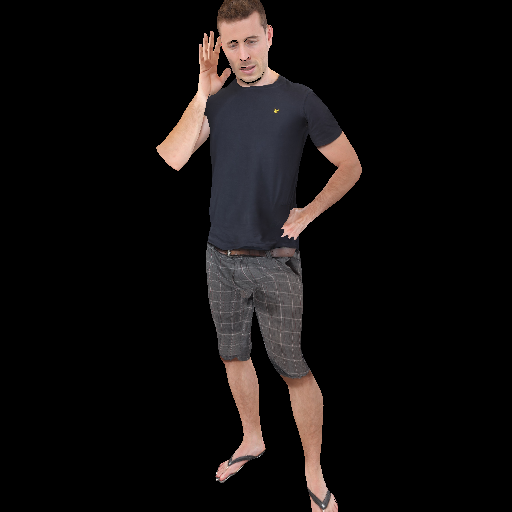

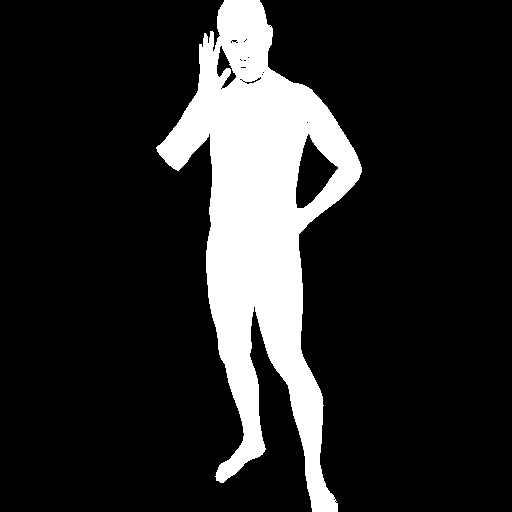

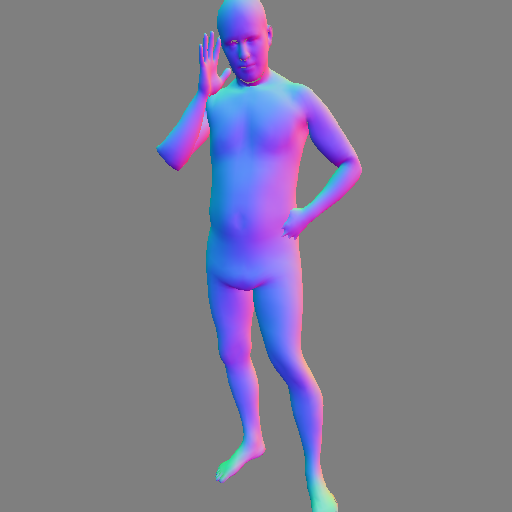

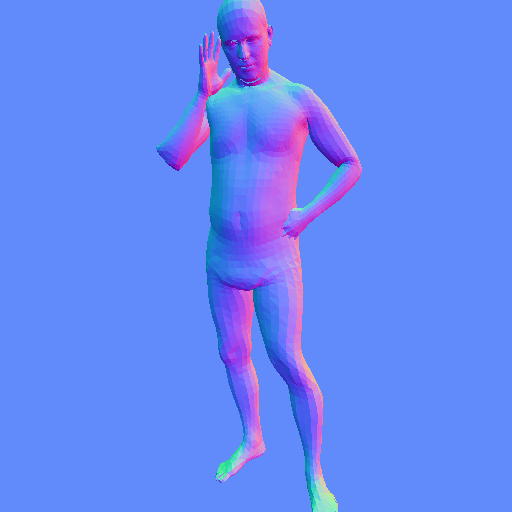

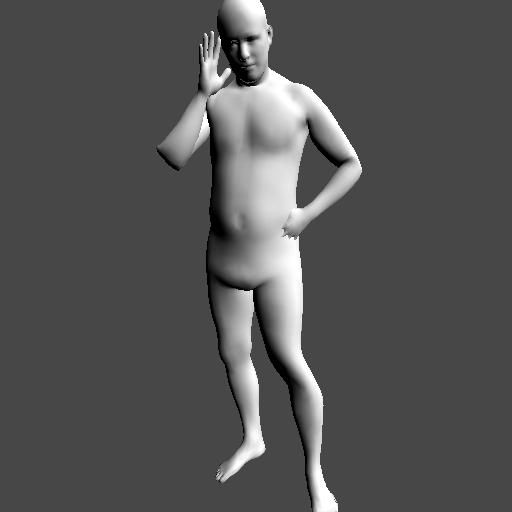

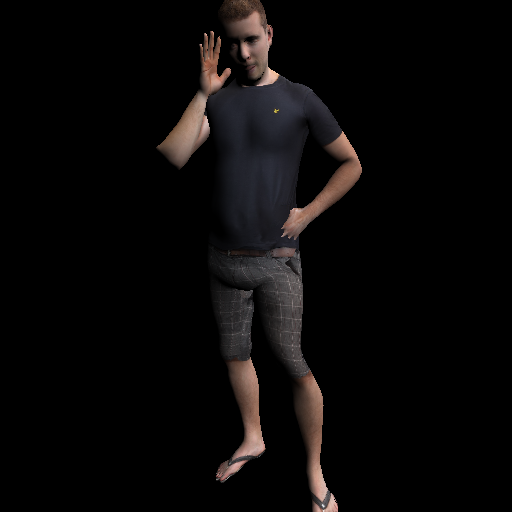

In [24]:
rendered = ((image*0.5+0.5)*mask).permute(0, 3, 1, 2)

display(ToPILImage()(rendered[0]))
display(ToPILImage()(mask.permute(0, 3, 1, 2)[0]))
display(ToPILImage()(world_normals.permute(0, 3, 1, 2)[0]*0.5+0.5))
display(ToPILImage()(image_normals.permute(0, 3, 1, 2)[0]*0.5+0.5))
display(ToPILImage()(image_lighting[0].clamp(0, 1)))
display(ToPILImage()((image_lighting.clamp(0, 1) * rendered)[0]))